<h1> Home Loan Prediction </h1>

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

sns.set()

In [2]:
df = pd.read_csv('data/loantrain.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [4]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
#Correct columns name inconsistences 
df = df.rename(columns={'Loan_ID': 'LoanID', 'Self_Employed': 'SelfEmployed', 'Loan_Amount_Term': 'LoanAmountTerm', 'Credit_History': 'CreditHistory', 'Property_Area': 'PropertyArea', 'Loan_Status': 'LoanStatus'})

In [6]:
df.nunique()

LoanID               614
Gender                 2
Married                2
Dependents             4
Education              2
SelfEmployed           2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
LoanAmountTerm        10
CreditHistory          2
PropertyArea           3
LoanStatus             2
dtype: int64

In [7]:
#Summary of the variables containing numerical values
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [8]:
df.isnull().sum()

LoanID                0
Gender               13
Married               3
Dependents           15
Education             0
SelfEmployed         32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
LoanAmountTerm       14
CreditHistory        50
PropertyArea          0
LoanStatus            0
dtype: int64

In [9]:
df[df['SelfEmployed'].isnull()][df['ApplicantIncome']>5000]

C:\Users\sirro\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,LoanID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus
95,LP001326,Male,No,0,Graduate,NaN,6782,0.0,NaN,360.0,NaN,Urban,N
107,LP001370,Male,No,0,Not Graduate,NaN,7333,0.0,120.0,360.0,1.0,Rural,N
114,LP001398,Male,No,0,Graduate,NaN,5050,0.0,118.0,360.0,1.0,Semiurban,Y
236,LP001786,Male,Yes,0,Graduate,NaN,5746,0.0,255.0,360.0,NaN,Urban,N
333,LP002101,Male,Yes,0,Graduate,NaN,63337,0.0,490.0,180.0,1.0,Urban,Y
336,LP002110,Male,Yes,1,Graduate,NaN,5250,688.0,160.0,360.0,1.0,Rural,Y
411,LP002319,Male,Yes,0,Graduate,NaN,6256,0.0,160.0,360.0,NaN,Urban,Y
432,LP002386,Male,No,0,Graduate,NaN,12876,0.0,405.0,360.0,1.0,Semiurban,Y
463,LP002489,Female,No,1,Not Graduate,NaN,5191,0.0,132.0,360.0,1.0,Semiurban,Y


Two of the applicant's income was over 10,000 and they live in the Urban and Semiurban areas therefore it is quite likely that they are selfemployed. One applicant lives in the rural area, he doesn't have a higher education and has an income of 7,333 may possible be selfemployed.  

In [10]:
df.loc[(df['SelfEmployed'].isnull()) & (df['ApplicantIncome']>7000), 'SelfEmployed'] = 'Yes'

In [11]:
df.isnull().sum()

LoanID                0
Gender               13
Married               3
Dependents           15
Education             0
SelfEmployed         29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
LoanAmountTerm       14
CreditHistory        50
PropertyArea          0
LoanStatus            0
dtype: int64

In [12]:
#Replace missing values in SelfEmployed column
df['SelfEmployed'].fillna('No', inplace=True)

In [13]:
df['LoanAmountTerm'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: LoanAmountTerm, dtype: int64

In [14]:
#Replace missing values in LoanAmountTerm column
df['LoanAmountTerm'].fillna(360, inplace=True)

In [15]:
#Number of ApplicantIncome below $10,0000
df[df['ApplicantIncome'] < 10000].shape

(559, 13)

In [16]:
#Number of CoapplicantIncome below $10,0000
df[df['CoapplicantIncome'] < 10000].shape

(608, 13)

In [17]:
#Drop row with missing data for Dependents and Loan amount
df2 = df.dropna(subset=['Dependents', 'LoanAmount'])

#Replace value
df2 = df2.replace(to_replace='3+',value='3')

#Change data type to int for dependents
df2.loc[:, 'Dependents'] = df2['Dependents'].astype(int)

In [18]:
#Summary of the variables containing numerical values after addressing some missing values. 
df2.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory
count,579.000000,579.000000,579.000000,579.000000,579.000000,530.000000
mean,0.761658,5432.177893,1651.635440,146.816926,342.072539,0.849057
std,1.014692,6228.236981,2992.599435,86.343049,64.546233,0.358332
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000
25%,0.000000,2879.000000,0.000000,100.000000,360.000000,1.000000
50%,0.000000,3775.000000,1229.000000,128.000000,360.000000,1.000000
75%,2.000000,5816.500000,2318.000000,169.000000,360.000000,1.000000
max,3.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [19]:
#Percent differences between the original data set and the updated
(df.describe() - df2.describe())/df.describe()*100

,ApplicantIncome,CoapplicantIncome,CreditHistory,Dependents,LoanAmount,LoanAmountTerm
count,5.700326,5.700326,6.028369,NaN,2.195946,5.700326
mean,-0.531486,-1.874462,-0.814300,NaN,-0.276455,0.098678
std,-1.951129,-2.267445,1.794136,NaN,-0.882986,-0.182534
min,0.000000,NaN,NaN,NaN,0.000000,0.000000
25%,-0.052129,NaN,0.000000,NaN,0.000000,0.000000
50%,0.983607,-3.407657,0.000000,NaN,0.000000,0.000000
75%,-0.371009,-0.903254,0.000000,NaN,-0.595238,0.000000
max,0.000000,0.000000,0.000000,NaN,0.000000,0.000000


In [20]:
#Add TotalIncome column
df2['TotalIncome'] = df2['ApplicantIncome'] + df2['CoapplicantIncome']

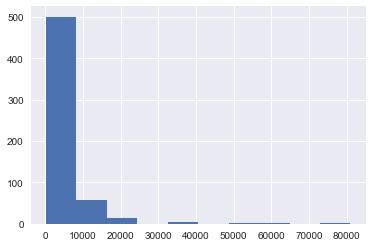

In [21]:
#Distribution of Income
plt.hist(df2['ApplicantIncome'])
plt.show()

In [22]:
#Explore Income Above $20,000
df2[df2['ApplicantIncome'] > 20000]

,LoanID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus,TotalIncome
126,LP001448,NaN,Yes,3,Graduate,No,23803,0.0,370.0,360.0,1.0,Rural,Y,23803.0
130,LP001469,Male,No,0,Graduate,Yes,20166,0.0,650.0,480.0,NaN,Urban,Y,20166.0
155,LP001536,Male,Yes,3,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y,39999.0
171,LP001585,NaN,Yes,3,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y,51763.0
183,LP001637,Male,Yes,1,Graduate,No,33846,0.0,260.0,360.0,1.0,Semiurban,N,33846.0
185,LP001640,Male,Yes,0,Graduate,Yes,39147,4750.0,120.0,360.0,1.0,Semiurban,Y,43897.0
308,LP001996,Male,No,0,Graduate,No,20233,0.0,480.0,360.0,1.0,Rural,N,20233.0
333,LP002101,Male,Yes,0,Graduate,Yes,63337,0.0,490.0,180.0,1.0,Urban,Y,63337.0
409,LP002317,Male,Yes,3,Graduate,No,81000,0.0,360.0,360.0,0.0,Rural,N,81000.0
443,LP002422,Male,No,1,Graduate,No,37719,0.0,152.0,360.0,1.0,Semiurban,Y,37719.0


The LoanID LP002317 and LP001448 had a similar application with incomes of 81,000 and 23,803. LP002317 was denied a loan therefore 81,000 could possibly be an outlier that can be safety be removed. 

In [23]:
df3 = df2[df2['ApplicantIncome'] < 80000]

In [24]:
df3.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,TotalIncome
count,578.000000,578.000000,578.000000,578.000000,578.000000,529.000000,578.000000
mean,0.757785,5301.437716,1654.492941,146.448097,342.041522,0.850662,6955.930657
std,1.011280,5379.978522,2994.400863,85.960119,64.597823,0.356759,5834.682216
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,1442.000000
25%,0.000000,2877.500000,0.000000,100.000000,360.000000,1.000000,4166.000000
50%,0.000000,3768.500000,1239.500000,127.500000,360.000000,1.000000,5416.500000
75%,2.000000,5811.250000,2324.000000,168.000000,360.000000,1.000000,7541.750000
max,3.000000,63337.000000,41667.000000,700.000000,480.000000,1.000000,63337.000000


In [25]:
#Calculate the minimum monthly payment with no interest and loan income ratio columns
df3['MonthlyPaymentNoInterest'] = df3['LoanAmount']*1000 / df3['LoanAmountTerm']
df3['LoanToIncomeRatio'] = df3['MonthlyPaymentNoInterest'] / df3['TotalIncome']
df3.head()

C:\Users\sirro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sirro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,LoanID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus,TotalIncome,MonthlyPaymentNoInterest,LoanToIncomeRatio
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,355.555556,0.058374
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,183.333333,0.061111
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,333.333333,0.067463
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,391.666667,0.065278
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0,741.666667,0.077152


In [26]:
df3.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,TotalIncome,MonthlyPaymentNoInterest,LoanToIncomeRatio
count,578.000000,578.000000,578.000000,578.000000,578.000000,529.000000,578.000000,578.000000,578.000000
mean,0.757785,5301.437716,1654.492941,146.448097,342.041522,0.850662,6955.930657,478.172063,0.077362
std,1.011280,5379.978522,2994.400863,85.960119,64.597823,0.356759,5834.682216,525.156117,0.080688
min,0.000000,150.000000,0.000000,9.000000,12.000000,0.000000,1442.000000,25.000000,0.007008
25%,0.000000,2877.500000,0.000000,100.000000,360.000000,1.000000,4166.000000,283.333333,0.055512
50%,0.000000,3768.500000,1239.500000,127.500000,360.000000,1.000000,5416.500000,362.500000,0.068970
75%,2.000000,5811.250000,2324.000000,168.000000,360.000000,1.000000,7541.750000,511.111111,0.081666
max,3.000000,63337.000000,41667.000000,700.000000,480.000000,1.000000,63337.000000,9250.000000,1.236873


In [27]:
df3[df3['MonthlyPaymentNoInterest'] > 5000]

,LoanID,Gender,Married,Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanAmountTerm,CreditHistory,PropertyArea,LoanStatus,TotalIncome,MonthlyPaymentNoInterest,LoanToIncomeRatio
497,LP002588,Male,Yes,0,Graduate,No,4625,2857.0,111.0,12.0,NaN,Urban,Y,7482.0,9250.0,1.2363


The monthly income for LP002588 is lower than the no interest monthly payment. Therefore the applicantion will be removed. 

In [28]:
df3 = df3[df3['MonthlyPaymentNoInterest'] < 5000]

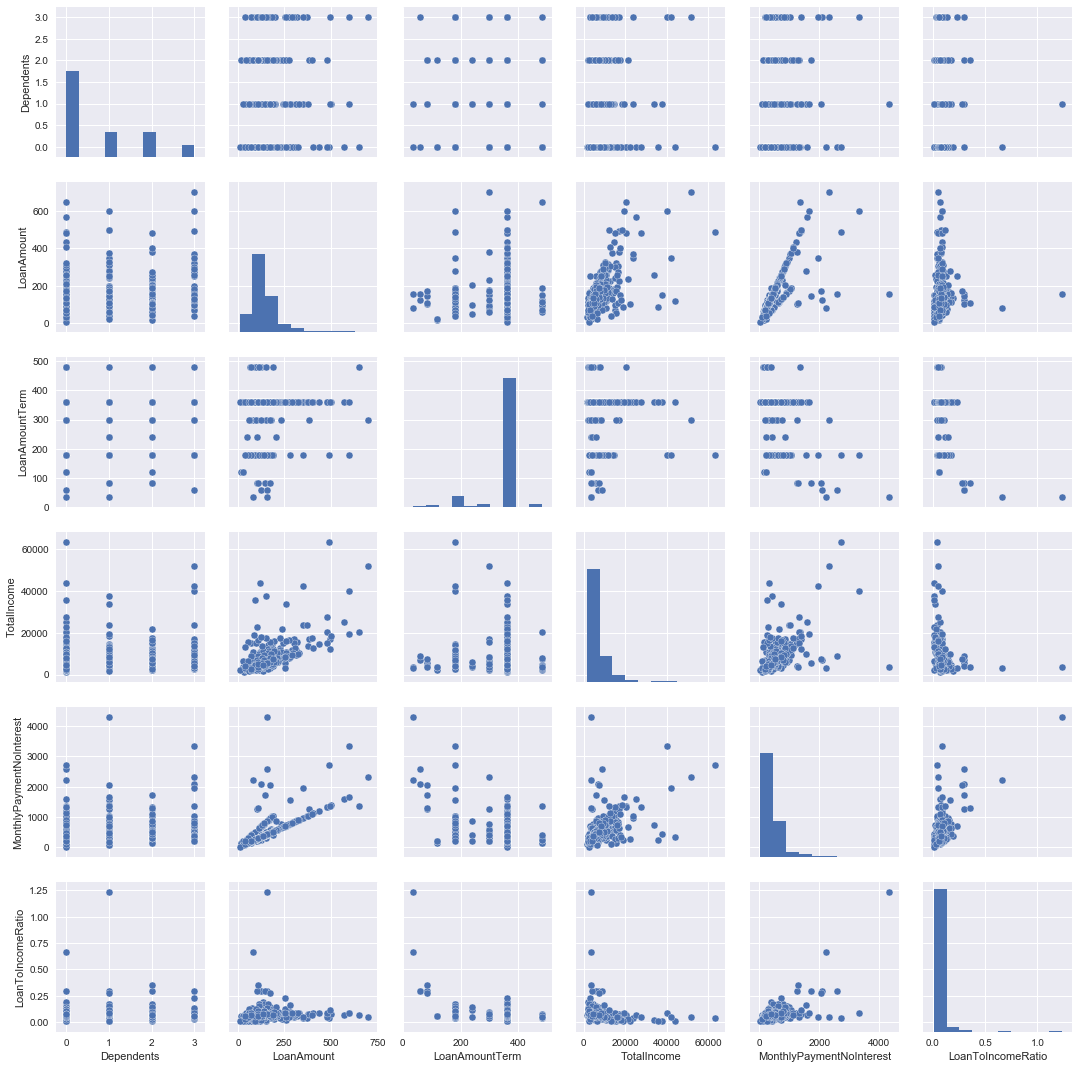

In [29]:
sns.pairplot(df3[['Dependents','LoanAmount','LoanAmountTerm','TotalIncome','MonthlyPaymentNoInterest','LoanToIncomeRatio']])
plt.show()

In [30]:
approved = df3[df3['LoanStatus'] == 'Y']
denied = df3[df3['LoanStatus'] == 'N']

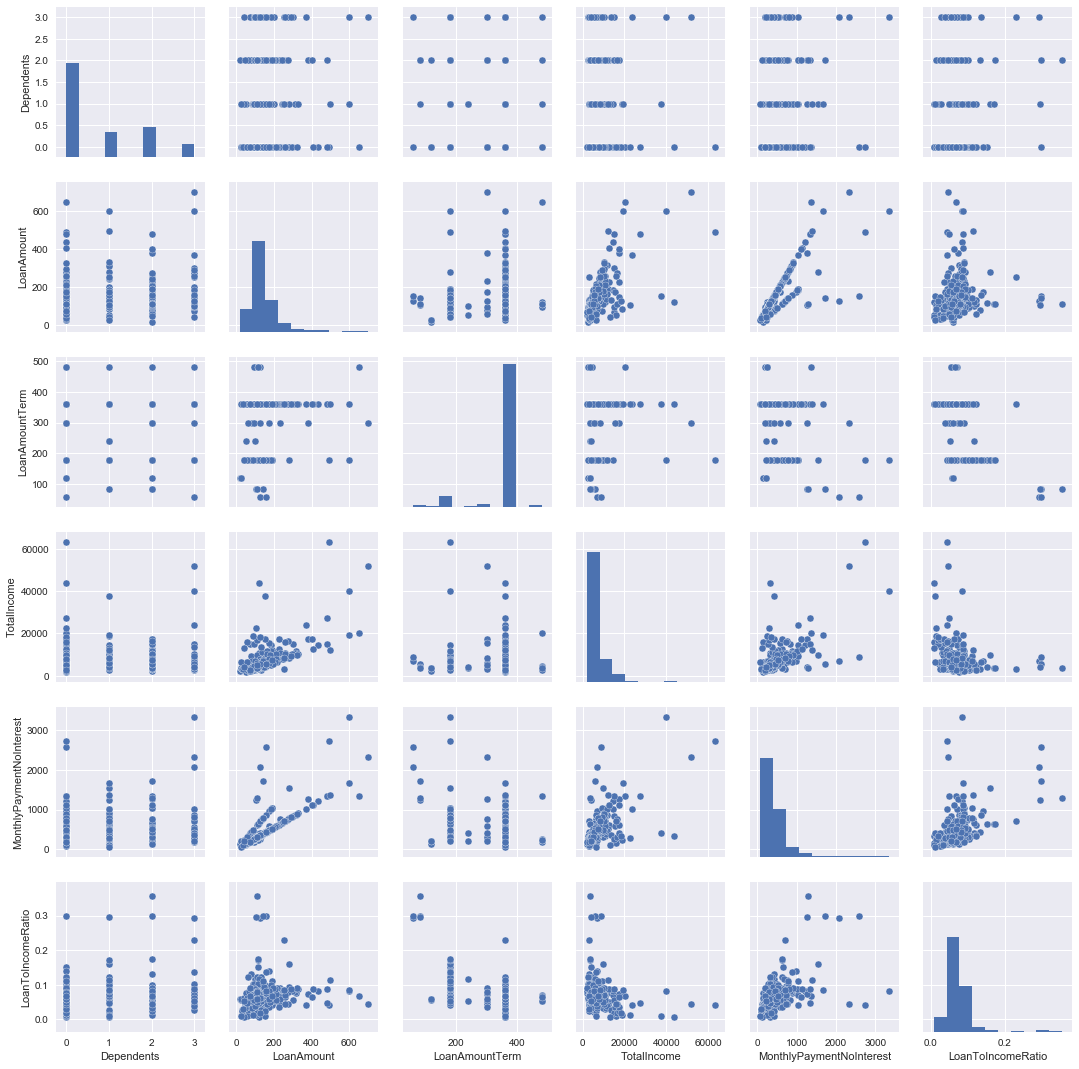

In [31]:
sns.pairplot(approved[['Dependents','LoanAmount','LoanAmountTerm','TotalIncome','MonthlyPaymentNoInterest','LoanToIncomeRatio']])
plt.show()

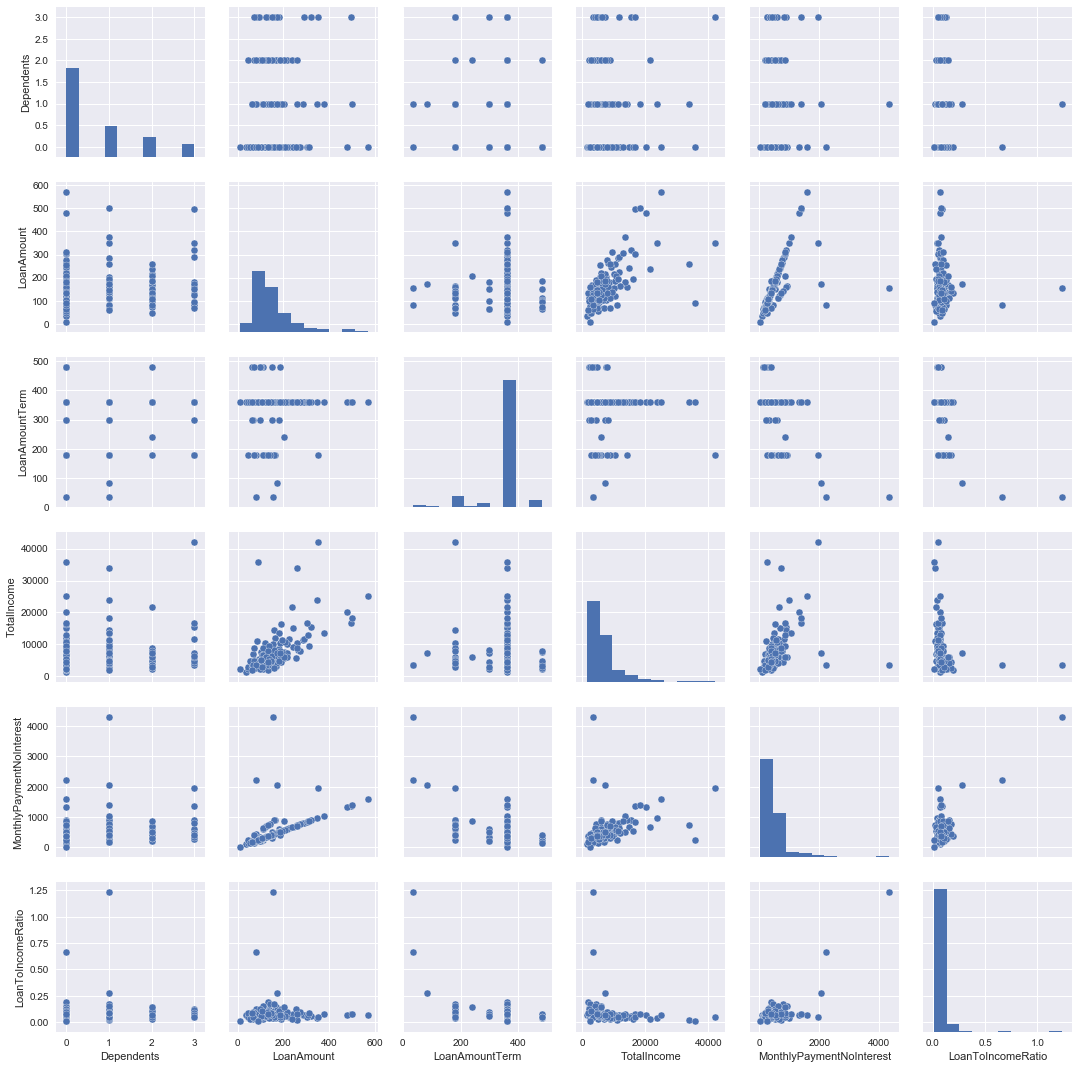

In [32]:
sns.pairplot(denied[['Dependents','LoanAmount','LoanAmountTerm','TotalIncome','MonthlyPaymentNoInterest','LoanToIncomeRatio']])
plt.show()

**What's the correlation between loan amount and total income?**

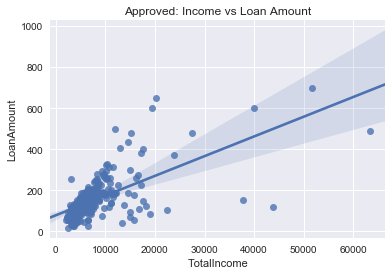

In [33]:
sns.regplot(approved['TotalIncome'], approved['LoanAmount'])
plt.title('Approved: Income vs Loan Amount')
plt.show()

H<sub>O</sub>: There is no linear relationship between total income and loan amount.<br>
H<sub>A</sub>: There is a linear relationship between total income and loan amount.


In [34]:
m, b, r, p, s = stats.linregress(approved['TotalIncome'], approved['LoanAmount'])
print('The correlation coefficient of our observed data is r =', round(r,3), 'and the p-value is p =', p)

The correlation coefficient of our observed data is r = 0.657 and the p-value is p = 4.696615306254406e-51


With a p-value that is infinitesimally below 0.05 there is very strong evidence to reject H<sub>O</sub> for the H<sub>A</sub>.

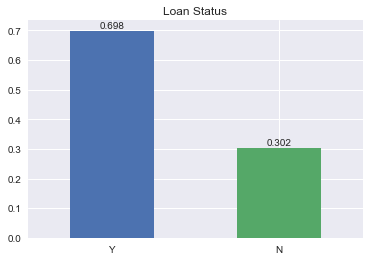

In [35]:
df3['LoanStatus'].value_counts(normalize=True).plot(kind='bar', rot=0)

#Add labels
x = list(round(df3['LoanStatus'].value_counts(normalize=True), 3).index)
y = round(df3['LoanStatus'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

plt.title('Loan Status')
plt.show()

**What is the rate of loan approval?** <br>
The loans are approved at a rate of 0.7.

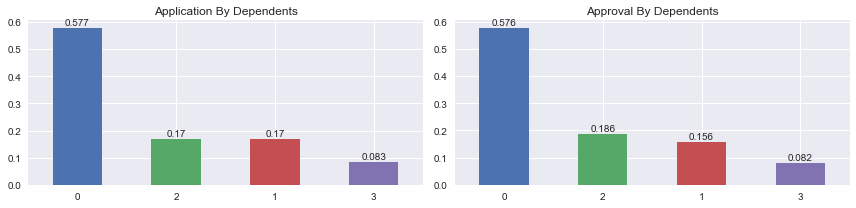

In [36]:
plt.figure(figsize=(12,3))

#Plot of Application By Property Area
plt.subplot(1,2,1)
df3['Dependents'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Application By Dependents')

#Add labels
x = list(round(df3['Dependents'].value_counts(normalize=True), 3).index)
y = round(df3['Dependents'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

#Plot of Approval By Property Area
plt.subplot(1,2,2)
approved['Dependents'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Approval By Dependents')

x = list(round(df3['Dependents'].value_counts(normalize=True), 3).index)
y = round(approved['Dependents'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')
    
plt.tight_layout()
plt.show()

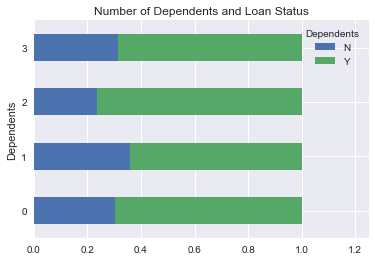

In [141]:
df3.groupby(['Dependents','LoanStatus']).size().groupby(level=[0]).apply(lambda x: x / x.sum()).unstack().plot.barh(stacked=True, rot=0)
plt.title('Number of Dependents and Loan Status')
plt.legend(title='Dependents')
plt.margins(0.25)
plt.show()

**How does the number of dependents influence loan approval?**<br>
The rates of application and approval are indeed similar. Therefore the number of dependents may not be taken into consideration when approving or denying a loan application.

H<sub>O</sub>: Loan approval is not related to the number of dependents. <br>
H<sub>A</sub>: Loan approval is related to the number of dependents.

In [59]:
dc, dp = stats.chi2_contingency(df3.groupby(['Dependents','LoanStatus']).size().unstack())[0:2]
print('The chi-square statistics is', round(dc, 2), 'and the p-value is',round(dp,3))

The chi-square statistics is 3.55 and the p-value is 0.314


With a p-value (0.314) is above 0.05 there isn't enough evidence to reject H<sub>O</sub> for the H<sub>A</sub>.

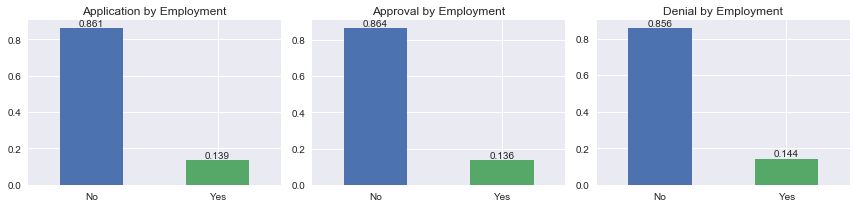

In [40]:
plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
df3['SelfEmployed'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Application by Employment')

#Add labels
x = list(round(df3['SelfEmployed'].value_counts(normalize=True), 3).index)
y = round(df3['SelfEmployed'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

#Plot of Application by Employment
plt.subplot(1,3,2)
approved['SelfEmployed'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Approval by Employment')

#Add labels
x = list(round(approved['SelfEmployed'].value_counts(normalize=True), 3).index)
y = round(approved['SelfEmployed'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

#Plot of Denial by Employment
plt.subplot(1,3,3)
denied['SelfEmployed'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Denial by Employment')

#Add labels
x = list(round(denied['SelfEmployed'].value_counts(normalize=True), 3).index)
y = round(denied['SelfEmployed'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

plt.tight_layout()
plt.show()

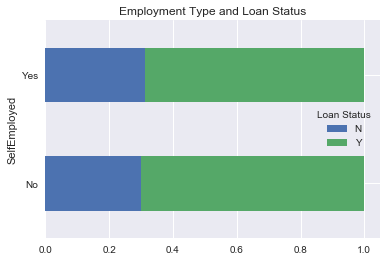

In [41]:
df3.groupby(['SelfEmployed','LoanStatus']).size().groupby(level=[0]).apply(lambda x: x / x.sum()).unstack().plot.barh(stacked=True, rot=0)
plt.title('Employment Type and Loan Status')
plt.legend(title='Loan Status')
plt.show()

**How does employment influence loan approval?**<br>
The rates of application and approval are indeed similar. Therefore self employment status may not be taken into consideration when approving or denying a loan application.

H<sub>O</sub>: There is no relationship between loan approval and employment type. <br>
H<sub>A</sub>: There is a relationship between loan approval and employment type.

In [60]:
sc, sp = stats.chi2_contingency(df3.groupby(['SelfEmployed','LoanStatus']).size().unstack())[0:2]
print('The chi-square statistics is', round(sc, 2), 'and the p-value is',round(sp,3))

The chi-square statistics is 0.01 and the p-value is 0.922


With a p-value (0.922) is above 0.05 there isn't enough evidence to reject H<sub>O</sub> for the H<sub>A</sub>.

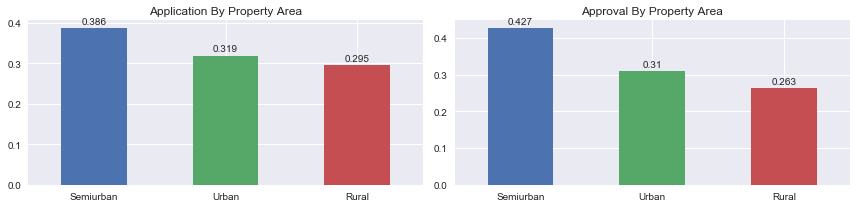

In [43]:
plt.figure(figsize=(12,3))

#Plot of Application By Property Area
plt.subplot(1,2,1)
df3['PropertyArea'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Application By Property Area')

#Add labels
x = list(round(df3['PropertyArea'].value_counts(normalize=True), 3).index)
y = round(df3['PropertyArea'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

#Plot of Approval By Property Area
plt.subplot(1,2,2)
approved['PropertyArea'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Approval By Property Area')

x = list(round(df3['PropertyArea'].value_counts(normalize=True), 3).index)
y = round(approved['PropertyArea'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')
    
plt.tight_layout()
plt.show()

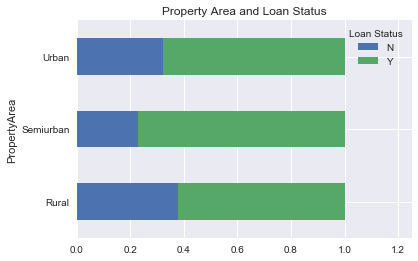

In [44]:
df3.groupby(['PropertyArea','LoanStatus'], sort=True).size().groupby(level=[0]).apply(lambda x: x / x.sum()).unstack().plot.barh(stacked=True, rot=0)
plt.title('Property Area and Loan Status')
plt.legend(title='Loan Status')
plt.margins(0.25)
plt.show()

**Does location affect loan approval rate?**<br>
The ratio of approved (0.427) semiurban loans is greater than the ratio of semiurban applicants (0.386). This can lead to the conclusion that your location can influence your application.

H<sub>O</sub>: The variables loan approval and property location are independent. <br>
H<sub>A</sub>: The variables loan approval and property location are not independent.

In [62]:
pc, pp = stats.chi2_contingency(df3.groupby(['PropertyArea','LoanStatus']).size().unstack())[0:2]
print('The chi-square statistics is', round(pc, 2), 'and the p-value is',round(pp,4))

The chi-square statistics is 10.47 and the p-value is 0.0053


The p-value (0.0053) is below 0.05 there is enough evidence to reject H<sub>O</sub> for the H<sub>A</sub>.

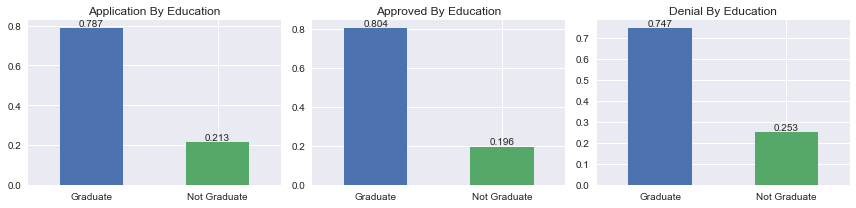

In [46]:
plt.figure(figsize=(12,3))

#Plot of Application by Education
plt.subplot(1,3,1)
df3['Education'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Application By Education')

#Add labels
x = list(round(df3['Education'].value_counts(normalize=True), 3).index)
y = round(df3['Education'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

#Plot of Approval by Education
plt.subplot(1,3,2)
approved['Education'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Approved By Education')

#Add labels
x = list(round(approved['Education'].value_counts(normalize=True), 3).index)
y = round(approved['Education'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

#Plot of Denial by Education
plt.subplot(1,3,3)
denied['Education'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Denial By Education')

#Add labels
x = list(round(denied['Education'].value_counts(normalize=True), 3).index)
y = round(denied['Education'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

plt.tight_layout()
plt.show()

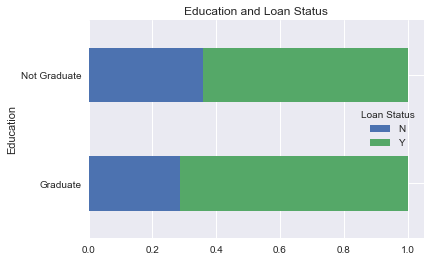

In [47]:
df3.groupby(['Education','LoanStatus']).size().groupby(level=[0]).apply(lambda x: x / x.sum()).unstack().plot.barh(stacked=True, rot=0)
plt.title('Education and Loan Status')
plt.legend(title='Loan Status')
plt.show()

**Is the education of the applicant taken into consideration when approving a loan?**<br>
A greater portion of more educated persons loans were approved (0.804) compared to the proportion that applied (0.787). While a great proportion of less educated individuals were denied (0.253) than the proportion that applied (0.213). There's a higher likelihood that those who are less educated earn less and therefore this can affect their chances of receiving a loan.

H<sub>O</sub>: There is no statistically significant relationship between loan approval and educational status. <br>
H<sub>A</sub>: There is a statistically significant relationship between loan approval and educational status.


In [63]:
ec, ep = stats.chi2_contingency(df3.groupby(['Education','LoanStatus']).size().unstack())[0:2]
print('The chi-square statistics is', round(ec, 2), 'and the p-value is',round(ep, 3))

The chi-square statistics is 2.01 and the p-value is 0.156


In [64]:
edu_a = df3.groupby(['Education','LoanStatus']).size()
edu_y = approved.groupby(['Education','LoanStatus']).size()
ec2, ep2 = proportions_ztest([edu_a[:2].sum(), edu_y[0]], [edu_a.sum(), edu_y.sum()])
print('The z-test statistics is', round(ec2, 2), 'and the p-value is',round(ep2, 3))

The z-test statistics is -0.65 and the p-value is 0.514


Both a p-values are above 0.05, therefore there isn't enough evidence to reject H<sub>O</sub> for the H<sub>A</sub>.

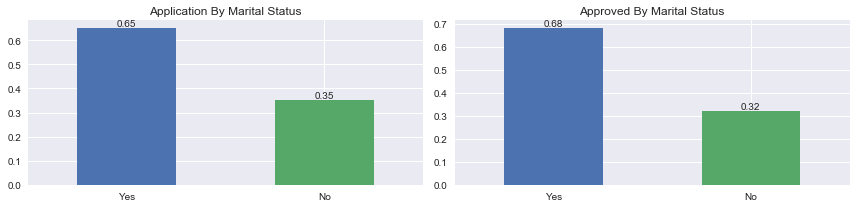

In [50]:
plt.figure(figsize=(12,3))

#Plot of Application by Marital Status
plt.subplot(1,2,1)
df3['Married'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Application By Marital Status')

#Add labels
x = list(round(df3['Married'].value_counts(normalize=True), 3).index)
y = round(df3['Married'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

#Plot of Approval by Marital Status
plt.subplot(1,2,2)
approved['Married'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Approved By Marital Status')

#Add labels
x = list(round(approved['Married'].value_counts(normalize=True), 3).index)
y = round(approved['Married'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

plt.tight_layout()
plt.show()

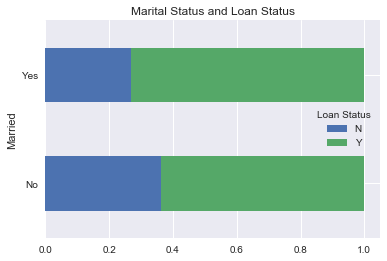

In [51]:
df3.groupby(['Married','LoanStatus']).size().groupby(level=[0]).apply(lambda x: x / x.sum()).unstack().plot.barh(stacked=True, rot=0, legend=True)
plt.title('Marital Status and Loan Status')
plt.legend(title='Loan Status')
plt.show()

**How does marital status affect loan approval?**<br>
More applicant are married and the proportion of approved (0.680) is greater that than which applied (0.651). Therefore it is more likely that married applicants may have their loans approved. It is more likely that they are willing to apply jointly improving their chances due to a greater combined income.

H<sub>O</sub>: There is no relationship between loan approval and marital status.<br>
H<sub>A</sub>: There is a relationship between loan approval and marital status.


In [65]:
mc, mp = stats.chi2_contingency(df3.groupby(['Married','LoanStatus']).size().unstack())[0:2]
print('The chi-square statistics is', round(mc, 2), 'and the p-value is',round(mp, 3))

The chi-square statistics is 4.85 and the p-value is 0.028


The p-value (0.028) is below 0.05, there is enough evidence to reject H<sub>O</sub> for the H<sub>A</sub>.

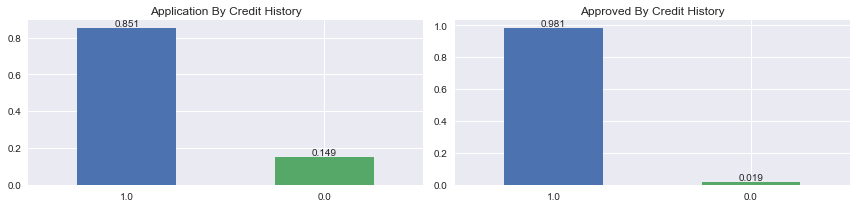

In [55]:
plt.figure(figsize=(12,3))

#Plot Application by Credit History
plt.subplot(1,2,1)
df3['CreditHistory'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Application By Credit History')

#Add labels
x = list(round(df3['CreditHistory'].value_counts(normalize=True), 3).index)
y = round(df3['CreditHistory'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

#Plot Approval by Credit History
plt.subplot(1,2,2)
approved['CreditHistory'].value_counts(normalize=True).plot(kind='bar', rot=0)
plt.title('Approved By Credit History')

#Add labels
x = list(round(approved['CreditHistory'].value_counts(normalize=True), 3).index)
y = round(approved['CreditHistory'].value_counts(normalize=True), 3)
x_pos = [i for i, _ in enumerate(x)]

for a, b in zip(x_pos,y):
    plt.text(a, b + 0.01, b, ha='center')

plt.tight_layout()
plt.show()

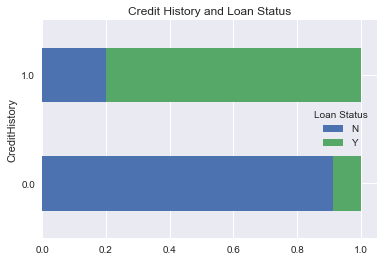

In [142]:
df3.groupby(['CreditHistory','LoanStatus']).size().groupby(level=[0]).apply(lambda x: x / x.sum()).unstack().plot.barh(stacked=True, rot=0, legend=True)
plt.legend(title='Loan Status')
plt.title('Credit History and Loan Status')
plt.show()

**Does having a credit history increase the chances of securing a loan?**<br>
Having a previous credit history (1.0) does increase the likelihood of receiving an approval. Creditors are more comfortable with someone who has already proven their credit worthiness, of the approved loans only 0.019 had no credit history. 

H<sub>O</sub>: There isn’t a statistical difference between loan approval and credit history.<br>
H<sub>A</sub>: There is a statistical difference between loan approval and credit history.


In [57]:
cc, cp = stats.chi2_contingency(df3.groupby(['CreditHistory','LoanStatus']).size().unstack())[0:2]
print('The chi-square statistics is', round(cc, 2), 'and the p-value is',cp)

The chi-square statistics is 156.75 and the p-value is 5.812103325545087e-36


With a p-value that is infinitesimally below 0.05 there is very strong evidence to reject H<sub>O</sub> for the H<sub>A</sub>.

In [80]:
denied[(denied['CreditHistory']==1.0) & (denied['PropertyArea']=='Rural')][['ApplicantIncome', 'CoapplicantIncome','LoanAmount','PropertyArea','TotalIncome','MonthlyPaymentNoInterest','LoanToIncomeRatio']].head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,PropertyArea,TotalIncome,MonthlyPaymentNoInterest,LoanToIncomeRatio
1,4583,1508.0,128.0,Rural,6091.0,355.555556,0.058374
13,1853,2840.0,114.0,Rural,4693.0,316.666667,0.067476
18,4887,0.0,133.0,Rural,4887.0,369.444444,0.075597
32,4692,0.0,106.0,Rural,4692.0,294.444444,0.062755
34,12500,3000.0,320.0,Rural,15500.0,888.888889,0.057348


In [79]:
approved[(approved['CreditHistory']==1.0) & (approved['PropertyArea']=='Rural')][['ApplicantIncome', 'CoapplicantIncome','LoanAmount','PropertyArea','TotalIncome','MonthlyPaymentNoInterest','LoanToIncomeRatio']].head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,PropertyArea,TotalIncome,MonthlyPaymentNoInterest,LoanToIncomeRatio
115,14583,0.0,185.0,Rural,14583.0,1027.777778,0.070478
124,4300,2014.0,194.0,Rural,6314.0,538.888889,0.085348
126,23803,0.0,370.0,Rural,23803.0,1027.777778,0.043178
151,2577,3750.0,152.0,Rural,6327.0,422.222222,0.066733
158,2980,2083.0,120.0,Rural,5063.0,333.333333,0.065837
